# Burgers equation

The paper about this work can ref https://www.researchgate.net/publication/359480166_Discontinuity_Computing_with_Physics-Informed_Neural_Network

In [6]:
import torch
import torch.nn as nn
import numpy as np
import time
import scipy.io
from smt.sampling_methods import LHS
import matplotlib
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
  #  random.seed(seed)
    torch.backends.cudnn.deterministic = True
    
setup_seed(124)

In [12]:
torch.backends.cuda.matmul.allow_tf32 = (
    False 
)
class layer(nn.Module):
    def __init__(self, n_in, n_out, activation):
        super().__init__()
        self.layer = nn.Linear(n_in, n_out)
        self.activation = activation

    def forward(self, x):
        x = self.layer(x)
        if self.activation:
            x = self.activation(x)
        return x
class DNN(nn.Module):
    def __init__(self, dim_in, dim_out, n_layer, n_node, activation=nn.Tanh()):
        super().__init__()
        self.net = nn.ModuleList()
        self.net.append(layer(dim_in, n_node, activation))
        for _ in range(n_layer):
            self.net.append(layer(n_node, n_node, activation))
        self.net.append(layer(n_node, dim_out, activation=None))
    def forward(self, x):
        out = x
        for layer in self.net:
            out = layer(out)
        return out
def gradients(outputs, inputs):
    return torch.autograd.grad(outputs, inputs,grad_outputs=torch.ones_like(outputs), create_graph=True)

In [13]:
   
def to_numpy(input):
    if isinstance(input, torch.Tensor):
        return input.detach().cpu().numpy()
    elif isinstance(input, np.ndarray):
        return input
    else:
        raise TypeError('Unknown type of input, expected torch.Tensor or ' \
                        'np.ndarray, but got {}'.format(type(input)))

def IC(x):
    N = len(x)
    u_init = np.zeros((x.shape[0]))                                                
    for i in range(N):
        u_init[i] = -np.sin(np.pi*(x[i,1]-1))
    return u_init

class PINN:
    def __init__(self):
        self.net = DNN(dim_in=2,dim_out=1,n_layer=3,n_node=30).to(device)
        self.optimizer = torch.optim.LBFGS(
              self.net.parameters(),
              lr=1.0,
              max_iter=20,
              max_eval=None,
              tolerance_grad=1e-05,
              #tolerance_change=1.finfo(float).eps,
              tolerance_change=1e-9,
              history_size=100,
              line_search_fn="strong_wolfe",)
        self.iter = 0 
    
    def closure(self):
        self.optimizer.zero_grad()
        
        loss_pde = self.loss_pde(x_int)                                   
        loss_ic = self.loss_ic(x_ic, u_ic)  
        loss = loss_pde + 10*loss_ic                                       

        self.iter = self.iter + 1
        print(f'epoch {self.iter} loss_pde:{loss_pde:.8f}, loss_ic:{loss_ic:.8f},loss:{loss:.8f}')
        #outputfile = open('loss_history_burgers.dat','a+')
        #print(f'{model.it}  {loss_pde:.6f}  {loss_ic:.6f}  {loss:.6f}',file=outputfile)
        loss.backward()
        return loss
    
    
    def loss_pde(self, x):
        y = self.net(x)                                                
        u = y[:, 0:1]
        
        U = u**2/2

        dU_g = gradients(U, x)[0]                                  
        U_x = dU_g[:, 1:]
        du_g = gradients(u, x)[0]                                 
        u_t,u_x = du_g[:, :1],du_g[:,1:]
        d = 0.1*(abs(u_x)-u_x) + 1
       # d = 1
        
        f = (((u_t + U_x)/d)**2).mean() 
         
        return f
    def res_pde(self,x):
        y = self.net(x)
        Res = np.zeros((x.shape[0]))                                  
        
        u = y[:, 0:1]
        U = u**2/2
        dU_g = gradients(U, x)[0]                                 
        U_x = dU_g[:, 1:]
        du_g = gradients(u, x)[0]                                  
        u_t,u_x = du_g[:, :1],du_g[:,1:]
        Res = (u_t + U_x)**2 
        return Res 
    
    def lambda_pde(self,x):
        y = self.net(x)
        Res = np.zeros((x.shape[0]))                                  
        
        u = y[:, 0:1]
        du_g = gradients(u, x)[0]                                  
        u_t,u_x = du_g[:, :1],du_g[:,1:]
        d = 0.1*(abs(u_x)-u_x) + 1
        return  d
        

    def loss_ic(self, x_ic, u_ic):
        y_ic = self.net(x_ic)                                                      
        u_ic_nn = y_ic[:, 0]
        loss_ics = ((u_ic_nn - u_ic) ** 2).mean()
        return loss_ics

In [14]:
num_x = 100                                                        
num_t = 100                                                       
num_i_train = 100                                         
num_f_train =  10000                                        
x = np.linspace(0, 2, num_x)                                   
t = np.linspace(0, 1.0, num_t)                                   
t_grid, x_grid = np.meshgrid(t, x)                             
T = t_grid.flatten()[:, None]                                  
X = x_grid.flatten()[:, None]                                  

id_ic = np.random.choice(num_x, num_i_train, replace=False)    
id_f = np.random.choice(num_x*num_t, num_f_train, replace=False)

x_ic = x_grid[id_ic, 0][:, None]                               
t_ic = t_grid[id_ic, 0][:, None]                               
x_ic_train = np.hstack((t_ic, x_ic))                               
u_ic_train = IC(x_ic_train)                 

x_int = X[:, 0][id_f, None]                                        
t_int = T[:, 0][id_f, None]                                        
x_int_train = np.hstack((t_int, x_int))                            

u_ic_train = IC(x_ic_train)                 

x_ic = torch.tensor(x_ic_train, dtype=torch.float32).to(device)
x_int = torch.tensor(x_int_train, requires_grad=True, dtype=torch.float32).to(device)
u_ic = torch.tensor(u_ic_train, dtype=torch.float32).to(device)


In [15]:
25*25

625

In [16]:
pinn = PINN()
for i in range(1000):
    pinn.closure()
    pinn.optimizer.step(pinn.closure)

epoch 1 loss_pde:0.00226536, loss_ic:0.49052292,loss:4.90749454
epoch 2 loss_pde:0.00226536, loss_ic:0.49052292,loss:4.90749454
epoch 3 loss_pde:0.00299882, loss_ic:0.47910276,loss:4.79402637
epoch 4 loss_pde:0.00866226, loss_ic:0.42264587,loss:4.23512077
epoch 5 loss_pde:0.03892421, loss_ic:0.30122134,loss:3.05113769
epoch 6 loss_pde:0.26362115, loss_ic:0.20938998,loss:2.35752082
epoch 7 loss_pde:0.10070670, loss_ic:0.24429451,loss:2.54365158
epoch 8 loss_pde:0.18799354, loss_ic:0.20234185,loss:2.21141195
epoch 9 loss_pde:0.19641635, loss_ic:0.20084327,loss:2.20484924
epoch 10 loss_pde:0.20487383, loss_ic:0.19673194,loss:2.17219329
epoch 11 loss_pde:0.20040283, loss_ic:0.18453068,loss:2.04570961
epoch 12 loss_pde:0.16887957, loss_ic:0.17776659,loss:1.94654536
epoch 13 loss_pde:0.14881833, loss_ic:0.17525579,loss:1.90137625
epoch 14 loss_pde:0.15333091, loss_ic:0.17253576,loss:1.87868857
epoch 15 loss_pde:0.16414697, loss_ic:0.16299026,loss:1.79404962
epoch 16 loss_pde:0.12229450, loss

epoch 139 loss_pde:0.19680847, loss_ic:0.00340545,loss:0.23086299
epoch 140 loss_pde:0.19749880, loss_ic:0.00328716,loss:0.23037036
epoch 141 loss_pde:0.19525762, loss_ic:0.00349890,loss:0.23024665
epoch 142 loss_pde:0.19626375, loss_ic:0.00338025,loss:0.23006622
epoch 143 loss_pde:0.19734426, loss_ic:0.00322041,loss:0.22954836
epoch 144 loss_pde:0.19676790, loss_ic:0.00319994,loss:0.22876731
epoch 145 loss_pde:0.19958331, loss_ic:0.00282803,loss:0.22786357
epoch 146 loss_pde:0.19400248, loss_ic:0.00352404,loss:0.22924289
epoch 147 loss_pde:0.19736670, loss_ic:0.00300413,loss:0.22740801
epoch 148 loss_pde:0.19759713, loss_ic:0.00294203,loss:0.22701743
epoch 149 loss_pde:0.19979595, loss_ic:0.00267119,loss:0.22650786
epoch 150 loss_pde:0.20023891, loss_ic:0.00257598,loss:0.22599867
epoch 151 loss_pde:0.20023891, loss_ic:0.00257598,loss:0.22599867
epoch 152 loss_pde:0.20023891, loss_ic:0.00257598,loss:0.22599867
epoch 153 loss_pde:0.19908781, loss_ic:0.00262657,loss:0.22535354
epoch 154 

epoch 268 loss_pde:0.13423257, loss_ic:0.00171640,loss:0.15139660
epoch 269 loss_pde:0.13423257, loss_ic:0.00171640,loss:0.15139660
epoch 270 loss_pde:0.13308784, loss_ic:0.00180563,loss:0.15114419
epoch 271 loss_pde:0.13456449, loss_ic:0.00162712,loss:0.15083568
epoch 272 loss_pde:0.13467722, loss_ic:0.00158970,loss:0.15057419
epoch 273 loss_pde:0.13379931, loss_ic:0.00164724,loss:0.15027171
epoch 274 loss_pde:0.13312058, loss_ic:0.00170039,loss:0.15012452
epoch 275 loss_pde:0.13278064, loss_ic:0.00172233,loss:0.15000394
epoch 276 loss_pde:0.13245454, loss_ic:0.00172710,loss:0.14972557
epoch 277 loss_pde:0.13226765, loss_ic:0.00171075,loss:0.14937519
epoch 278 loss_pde:0.13310915, loss_ic:0.00159366,loss:0.14904577
epoch 279 loss_pde:0.13339527, loss_ic:0.00153762,loss:0.14877148
epoch 280 loss_pde:0.13255879, loss_ic:0.00159215,loss:0.14848027
epoch 281 loss_pde:0.13269591, loss_ic:0.00155689,loss:0.14826481
epoch 282 loss_pde:0.13206854, loss_ic:0.00161122,loss:0.14818075
epoch 283 

epoch 393 loss_pde:0.11283728, loss_ic:0.00116118,loss:0.12444907
epoch 394 loss_pde:0.11257656, loss_ic:0.00118011,loss:0.12437767
epoch 395 loss_pde:0.11240235, loss_ic:0.00119094,loss:0.12431179
epoch 396 loss_pde:0.11239175, loss_ic:0.00118923,loss:0.12428404
epoch 397 loss_pde:0.11228280, loss_ic:0.00119405,loss:0.12422334
epoch 398 loss_pde:0.11258797, loss_ic:0.00114761,loss:0.12406409
epoch 399 loss_pde:0.11223167, loss_ic:0.00116342,loss:0.12386590
epoch 400 loss_pde:0.11281552, loss_ic:0.00107843,loss:0.12359983
epoch 401 loss_pde:0.11220205, loss_ic:0.00111468,loss:0.12334885
epoch 402 loss_pde:0.11169748, loss_ic:0.00113638,loss:0.12306131
epoch 403 loss_pde:0.11146455, loss_ic:0.00112961,loss:0.12276067
epoch 404 loss_pde:0.11026937, loss_ic:0.00121403,loss:0.12240967
epoch 405 loss_pde:0.11056816, loss_ic:0.00115621,loss:0.12213021
epoch 406 loss_pde:0.11056816, loss_ic:0.00115621,loss:0.12213021
epoch 407 loss_pde:0.11056816, loss_ic:0.00115621,loss:0.12213021
epoch 408 

epoch 521 loss_pde:0.10122836, loss_ic:0.00085199,loss:0.10974827
epoch 522 loss_pde:0.10100914, loss_ic:0.00087064,loss:0.10971551
epoch 523 loss_pde:0.10100914, loss_ic:0.00087064,loss:0.10971551
epoch 524 loss_pde:0.10100914, loss_ic:0.00087064,loss:0.10971551
epoch 525 loss_pde:0.10113345, loss_ic:0.00085235,loss:0.10965694
epoch 526 loss_pde:0.10097782, loss_ic:0.00085516,loss:0.10952941
epoch 527 loss_pde:0.10120595, loss_ic:0.00081726,loss:0.10937858
epoch 528 loss_pde:0.10075200, loss_ic:0.00084071,loss:0.10915911
epoch 529 loss_pde:0.10146987, loss_ic:0.00076798,loss:0.10914965
epoch 530 loss_pde:0.10109457, loss_ic:0.00080090,loss:0.10910355
epoch 531 loss_pde:0.10054820, loss_ic:0.00085230,loss:0.10907120
epoch 532 loss_pde:0.10061184, loss_ic:0.00084280,loss:0.10903989
epoch 533 loss_pde:0.10052864, loss_ic:0.00084722,loss:0.10900084
epoch 534 loss_pde:0.10031995, loss_ic:0.00086215,loss:0.10894150
epoch 535 loss_pde:0.10008810, loss_ic:0.00087278,loss:0.10881593
epoch 536 

epoch 660 loss_pde:0.08818481, loss_ic:0.00131654,loss:0.10135026
epoch 661 loss_pde:0.09066897, loss_ic:0.00086045,loss:0.09927350
epoch 662 loss_pde:0.09146405, loss_ic:0.00087456,loss:0.10020962
epoch 663 loss_pde:0.09044867, loss_ic:0.00083905,loss:0.09883922
epoch 664 loss_pde:0.09255317, loss_ic:0.00091139,loss:0.10166707
epoch 665 loss_pde:0.09023878, loss_ic:0.00083694,loss:0.09860815
epoch 666 loss_pde:0.09404168, loss_ic:0.00088944,loss:0.10293604
epoch 667 loss_pde:0.09024553, loss_ic:0.00081189,loss:0.09836447
epoch 668 loss_pde:0.09177544, loss_ic:0.00065916,loss:0.09836699
epoch 669 loss_pde:0.09085587, loss_ic:0.00072964,loss:0.09815229
epoch 670 loss_pde:0.09085587, loss_ic:0.00072964,loss:0.09815229
epoch 671 loss_pde:0.09085587, loss_ic:0.00072964,loss:0.09815229
epoch 672 loss_pde:0.09063762, loss_ic:0.00085420,loss:0.09917961
epoch 673 loss_pde:0.09040674, loss_ic:0.00075781,loss:0.09798484
epoch 674 loss_pde:0.08858731, loss_ic:0.00093568,loss:0.09794411
epoch 675 

epoch 798 loss_pde:0.05788784, loss_ic:0.00060609,loss:0.06394877
epoch 799 loss_pde:0.05744961, loss_ic:0.00060847,loss:0.06353433
epoch 800 loss_pde:0.05734695, loss_ic:0.00059077,loss:0.06325470
epoch 801 loss_pde:0.05763774, loss_ic:0.00054196,loss:0.06305731
epoch 802 loss_pde:0.05656359, loss_ic:0.00064091,loss:0.06297266
epoch 803 loss_pde:0.05686584, loss_ic:0.00057498,loss:0.06261565
epoch 804 loss_pde:0.05685323, loss_ic:0.00055753,loss:0.06242858
epoch 805 loss_pde:0.05688743, loss_ic:0.00053009,loss:0.06218829
epoch 806 loss_pde:0.05658443, loss_ic:0.00054004,loss:0.06198482
epoch 807 loss_pde:0.05637085, loss_ic:0.00054578,loss:0.06182869
epoch 808 loss_pde:0.05594976, loss_ic:0.00056463,loss:0.06159609
epoch 809 loss_pde:0.05596133, loss_ic:0.00053142,loss:0.06127556
epoch 810 loss_pde:0.05481567, loss_ic:0.00064644,loss:0.06128011
epoch 811 loss_pde:0.05521825, loss_ic:0.00058395,loss:0.06105773
epoch 812 loss_pde:0.05521825, loss_ic:0.00058395,loss:0.06105773
epoch 813 

epoch 932 loss_pde:0.02917913, loss_ic:0.00049994,loss:0.03417854
epoch 933 loss_pde:0.02939036, loss_ic:0.00045959,loss:0.03398629
epoch 934 loss_pde:0.02943417, loss_ic:0.00043547,loss:0.03378889
epoch 935 loss_pde:0.02951352, loss_ic:0.00040057,loss:0.03351919
epoch 936 loss_pde:0.02940755, loss_ic:0.00038796,loss:0.03328714
epoch 937 loss_pde:0.02936167, loss_ic:0.00037823,loss:0.03314400
epoch 938 loss_pde:0.02920979, loss_ic:0.00037619,loss:0.03297167
epoch 939 loss_pde:0.02892817, loss_ic:0.00037713,loss:0.03269951
epoch 940 loss_pde:0.02831287, loss_ic:0.00038191,loss:0.03213196
epoch 941 loss_pde:0.02788813, loss_ic:0.00036835,loss:0.03157164
epoch 942 loss_pde:0.02862270, loss_ic:0.00029029,loss:0.03152565
epoch 943 loss_pde:0.02801890, loss_ic:0.00031881,loss:0.03120700
epoch 944 loss_pde:0.02793149, loss_ic:0.00029052,loss:0.03083666
epoch 945 loss_pde:0.02731498, loss_ic:0.00039347,loss:0.03124972
epoch 946 loss_pde:0.02744864, loss_ic:0.00031780,loss:0.03062659
epoch 947 

epoch 1066 loss_pde:0.01413668, loss_ic:0.00015185,loss:0.01565520
epoch 1067 loss_pde:0.01411782, loss_ic:0.00015198,loss:0.01563758
epoch 1068 loss_pde:0.01407277, loss_ic:0.00015274,loss:0.01560022
epoch 1069 loss_pde:0.01407277, loss_ic:0.00015274,loss:0.01560022
epoch 1070 loss_pde:0.01407277, loss_ic:0.00015274,loss:0.01560022
epoch 1071 loss_pde:0.01408025, loss_ic:0.00014874,loss:0.01556762
epoch 1072 loss_pde:0.01400717, loss_ic:0.00016065,loss:0.01561363
epoch 1073 loss_pde:0.01403208, loss_ic:0.00015229,loss:0.01555494
epoch 1074 loss_pde:0.01404438, loss_ic:0.00014697,loss:0.01551407
epoch 1075 loss_pde:0.01402145, loss_ic:0.00014197,loss:0.01544119
epoch 1076 loss_pde:0.01398271, loss_ic:0.00013716,loss:0.01535432
epoch 1077 loss_pde:0.01385637, loss_ic:0.00013889,loss:0.01524530
epoch 1078 loss_pde:0.01355693, loss_ic:0.00015133,loss:0.01507023
epoch 1079 loss_pde:0.01356382, loss_ic:0.00014469,loss:0.01501073
epoch 1080 loss_pde:0.01347581, loss_ic:0.00014758,loss:0.0149

epoch 1204 loss_pde:0.00936078, loss_ic:0.00014052,loss:0.01076595
epoch 1205 loss_pde:0.00926531, loss_ic:0.00014352,loss:0.01070053
epoch 1206 loss_pde:0.00919622, loss_ic:0.00014449,loss:0.01064112
epoch 1207 loss_pde:0.00913971, loss_ic:0.00014255,loss:0.01056526
epoch 1208 loss_pde:0.00917970, loss_ic:0.00014240,loss:0.01060372
epoch 1209 loss_pde:0.00911055, loss_ic:0.00014202,loss:0.01053076
epoch 1210 loss_pde:0.00911055, loss_ic:0.00014202,loss:0.01053076
epoch 1211 loss_pde:0.00911055, loss_ic:0.00014202,loss:0.01053076
epoch 1212 loss_pde:0.00912758, loss_ic:0.00013561,loss:0.01048367
epoch 1213 loss_pde:0.00910580, loss_ic:0.00013280,loss:0.01043375
epoch 1214 loss_pde:0.00900773, loss_ic:0.00013616,loss:0.01036935
epoch 1215 loss_pde:0.00902268, loss_ic:0.00012859,loss:0.01030855
epoch 1216 loss_pde:0.00895717, loss_ic:0.00012760,loss:0.01023320
epoch 1217 loss_pde:0.00894837, loss_ic:0.00012553,loss:0.01020369
epoch 1218 loss_pde:0.00890764, loss_ic:0.00012768,loss:0.0101

epoch 1341 loss_pde:0.00598340, loss_ic:0.00008511,loss:0.00683452
epoch 1342 loss_pde:0.00631382, loss_ic:0.00010094,loss:0.00732325
epoch 1343 loss_pde:0.00596984, loss_ic:0.00008555,loss:0.00682537
epoch 1344 loss_pde:0.00594485, loss_ic:0.00008509,loss:0.00679571
epoch 1345 loss_pde:0.00585541, loss_ic:0.00008630,loss:0.00671841
epoch 1346 loss_pde:0.00579094, loss_ic:0.00008753,loss:0.00666623
epoch 1347 loss_pde:0.00573869, loss_ic:0.00008692,loss:0.00660788
epoch 1348 loss_pde:0.00573241, loss_ic:0.00008364,loss:0.00656883
epoch 1349 loss_pde:0.00642211, loss_ic:0.00014239,loss:0.00784599
epoch 1350 loss_pde:0.00570582, loss_ic:0.00008562,loss:0.00656202
epoch 1351 loss_pde:0.00570154, loss_ic:0.00008351,loss:0.00653665
epoch 1352 loss_pde:0.00566449, loss_ic:0.00008553,loss:0.00651977
epoch 1353 loss_pde:0.00564315, loss_ic:0.00008407,loss:0.00648389
epoch 1354 loss_pde:0.00563507, loss_ic:0.00008175,loss:0.00645258
epoch 1355 loss_pde:0.00563507, loss_ic:0.00008175,loss:0.0064

epoch 1477 loss_pde:0.00373571, loss_ic:0.00006261,loss:0.00436182
epoch 1478 loss_pde:0.00372805, loss_ic:0.00006312,loss:0.00435921
epoch 1479 loss_pde:0.00372347, loss_ic:0.00006341,loss:0.00435757
epoch 1480 loss_pde:0.00371832, loss_ic:0.00006367,loss:0.00435504
epoch 1481 loss_pde:0.00370581, loss_ic:0.00006449,loss:0.00435068
epoch 1482 loss_pde:0.00370219, loss_ic:0.00006392,loss:0.00434143
epoch 1483 loss_pde:0.00370509, loss_ic:0.00006397,loss:0.00434481
epoch 1484 loss_pde:0.00369107, loss_ic:0.00006385,loss:0.00432953
epoch 1485 loss_pde:0.00368525, loss_ic:0.00006247,loss:0.00430996
epoch 1486 loss_pde:0.00368102, loss_ic:0.00005974,loss:0.00427840
epoch 1487 loss_pde:0.00368445, loss_ic:0.00005731,loss:0.00425754
epoch 1488 loss_pde:0.00366927, loss_ic:0.00005594,loss:0.00422865
epoch 1489 loss_pde:0.00365390, loss_ic:0.00005435,loss:0.00419740
epoch 1490 loss_pde:0.00365845, loss_ic:0.00005200,loss:0.00417845
epoch 1491 loss_pde:0.00363186, loss_ic:0.00005269,loss:0.0041

epoch 1617 loss_pde:0.00280711, loss_ic:0.00003651,loss:0.00317218
epoch 1618 loss_pde:0.00281228, loss_ic:0.00003594,loss:0.00317165
epoch 1619 loss_pde:0.00283957, loss_ic:0.00003335,loss:0.00317307
epoch 1620 loss_pde:0.00282192, loss_ic:0.00003472,loss:0.00316916
epoch 1621 loss_pde:0.00281152, loss_ic:0.00003553,loss:0.00316682
epoch 1622 loss_pde:0.00280527, loss_ic:0.00003595,loss:0.00316477
epoch 1623 loss_pde:0.00280199, loss_ic:0.00003597,loss:0.00316168
epoch 1624 loss_pde:0.00279984, loss_ic:0.00003581,loss:0.00315794
epoch 1625 loss_pde:0.00280460, loss_ic:0.00003479,loss:0.00315248
epoch 1626 loss_pde:0.00281023, loss_ic:0.00003341,loss:0.00314431
epoch 1627 loss_pde:0.00280992, loss_ic:0.00003247,loss:0.00313457
epoch 1628 loss_pde:0.00281729, loss_ic:0.00003057,loss:0.00312299
epoch 1629 loss_pde:0.00280402, loss_ic:0.00003114,loss:0.00311540
epoch 1630 loss_pde:0.00278526, loss_ic:0.00003229,loss:0.00310814
epoch 1631 loss_pde:0.00277623, loss_ic:0.00003228,loss:0.0030

epoch 1749 loss_pde:0.00237372, loss_ic:0.00002807,loss:0.00265446
epoch 1750 loss_pde:0.00237894, loss_ic:0.00002740,loss:0.00265291
epoch 1751 loss_pde:0.00238214, loss_ic:0.00002688,loss:0.00265091
epoch 1752 loss_pde:0.00238633, loss_ic:0.00002620,loss:0.00264838
epoch 1753 loss_pde:0.00238796, loss_ic:0.00002586,loss:0.00264652
epoch 1754 loss_pde:0.00238796, loss_ic:0.00002586,loss:0.00264652
epoch 1755 loss_pde:0.00238796, loss_ic:0.00002586,loss:0.00264652
epoch 1756 loss_pde:0.00238680, loss_ic:0.00002577,loss:0.00264450
epoch 1757 loss_pde:0.00238293, loss_ic:0.00002594,loss:0.00264233
epoch 1758 loss_pde:0.00236868, loss_ic:0.00002713,loss:0.00264002
epoch 1759 loss_pde:0.00237863, loss_ic:0.00002607,loss:0.00263929
epoch 1760 loss_pde:0.00236973, loss_ic:0.00002664,loss:0.00263611
epoch 1761 loss_pde:0.00235013, loss_ic:0.00002888,loss:0.00263888
epoch 1762 loss_pde:0.00235979, loss_ic:0.00002744,loss:0.00263422
epoch 1763 loss_pde:0.00235908, loss_ic:0.00002720,loss:0.0026

epoch 1881 loss_pde:0.00206056, loss_ic:0.00002529,loss:0.00231347
epoch 1882 loss_pde:0.00205423, loss_ic:0.00002582,loss:0.00231241
epoch 1883 loss_pde:0.00205411, loss_ic:0.00002575,loss:0.00231157
epoch 1884 loss_pde:0.00205360, loss_ic:0.00002573,loss:0.00231089
epoch 1885 loss_pde:0.00205484, loss_ic:0.00002552,loss:0.00231000
epoch 1886 loss_pde:0.00205353, loss_ic:0.00002557,loss:0.00230921
epoch 1887 loss_pde:0.00205533, loss_ic:0.00002545,loss:0.00230988
epoch 1888 loss_pde:0.00205375, loss_ic:0.00002550,loss:0.00230872
epoch 1889 loss_pde:0.00205245, loss_ic:0.00002638,loss:0.00231625
epoch 1890 loss_pde:0.00205145, loss_ic:0.00002562,loss:0.00230761
epoch 1891 loss_pde:0.00204921, loss_ic:0.00002570,loss:0.00230617
epoch 1892 loss_pde:0.00204791, loss_ic:0.00002568,loss:0.00230472
epoch 1893 loss_pde:0.00205472, loss_ic:0.00002493,loss:0.00230407
epoch 1894 loss_pde:0.00205156, loss_ic:0.00002512,loss:0.00230272
epoch 1895 loss_pde:0.00204965, loss_ic:0.00002522,loss:0.0023

epoch 2017 loss_pde:0.00191580, loss_ic:0.00001872,loss:0.00210295
epoch 2018 loss_pde:0.00191211, loss_ic:0.00001893,loss:0.00210144
epoch 2019 loss_pde:0.00191379, loss_ic:0.00001865,loss:0.00210027
epoch 2020 loss_pde:0.00190868, loss_ic:0.00001905,loss:0.00209922
epoch 2021 loss_pde:0.00190251, loss_ic:0.00001947,loss:0.00209717
epoch 2022 loss_pde:0.00190180, loss_ic:0.00001935,loss:0.00209526
epoch 2023 loss_pde:0.00190145, loss_ic:0.00001921,loss:0.00209352
epoch 2024 loss_pde:0.00190040, loss_ic:0.00001919,loss:0.00209234
epoch 2025 loss_pde:0.00189804, loss_ic:0.00001927,loss:0.00209072
epoch 2026 loss_pde:0.00189827, loss_ic:0.00001924,loss:0.00209068
epoch 2027 loss_pde:0.00189755, loss_ic:0.00001925,loss:0.00209000
epoch 2028 loss_pde:0.00189917, loss_ic:0.00001899,loss:0.00208904
epoch 2029 loss_pde:0.00189951, loss_ic:0.00001884,loss:0.00208794
epoch 2030 loss_pde:0.00190149, loss_ic:0.00001857,loss:0.00208716
epoch 2031 loss_pde:0.00190106, loss_ic:0.00001852,loss:0.0020

epoch 2150 loss_pde:0.00177360, loss_ic:0.00001555,loss:0.00192908
epoch 2151 loss_pde:0.00177101, loss_ic:0.00001565,loss:0.00192754
epoch 2152 loss_pde:0.00177233, loss_ic:0.00001535,loss:0.00192583
epoch 2153 loss_pde:0.00177554, loss_ic:0.00001482,loss:0.00192371
epoch 2154 loss_pde:0.00177554, loss_ic:0.00001482,loss:0.00192371
epoch 2155 loss_pde:0.00177554, loss_ic:0.00001482,loss:0.00192371
epoch 2156 loss_pde:0.00176578, loss_ic:0.00001560,loss:0.00192173
epoch 2157 loss_pde:0.00175548, loss_ic:0.00001633,loss:0.00191882
epoch 2158 loss_pde:0.00175123, loss_ic:0.00001654,loss:0.00191663
epoch 2159 loss_pde:0.00174556, loss_ic:0.00001678,loss:0.00191334
epoch 2160 loss_pde:0.00174553, loss_ic:0.00001637,loss:0.00190921
epoch 2161 loss_pde:0.00174517, loss_ic:0.00001591,loss:0.00190424
epoch 2162 loss_pde:0.00174323, loss_ic:0.00001604,loss:0.00190361
epoch 2163 loss_pde:0.00173902, loss_ic:0.00001594,loss:0.00189845
epoch 2164 loss_pde:0.00172725, loss_ic:0.00001619,loss:0.0018

epoch 2286 loss_pde:0.00140673, loss_ic:0.00001453,loss:0.00155202
epoch 2287 loss_pde:0.00140494, loss_ic:0.00001463,loss:0.00155127
epoch 2288 loss_pde:0.00140139, loss_ic:0.00001487,loss:0.00155013
epoch 2289 loss_pde:0.00139817, loss_ic:0.00001502,loss:0.00154835
epoch 2290 loss_pde:0.00139220, loss_ic:0.00001538,loss:0.00154603
epoch 2291 loss_pde:0.00146969, loss_ic:0.00001324,loss:0.00160209
epoch 2292 loss_pde:0.00139493, loss_ic:0.00001488,loss:0.00154369
epoch 2293 loss_pde:0.00138936, loss_ic:0.00001522,loss:0.00154153
epoch 2294 loss_pde:0.00138936, loss_ic:0.00001522,loss:0.00154153
epoch 2295 loss_pde:0.00138936, loss_ic:0.00001522,loss:0.00154153
epoch 2296 loss_pde:0.00139007, loss_ic:0.00001489,loss:0.00153897
epoch 2297 loss_pde:0.00139582, loss_ic:0.00001416,loss:0.00153741
epoch 2298 loss_pde:0.00139279, loss_ic:0.00001434,loss:0.00153623
epoch 2299 loss_pde:0.00142170, loss_ic:0.00001300,loss:0.00155169
epoch 2300 loss_pde:0.00139557, loss_ic:0.00001401,loss:0.0015

epoch 2420 loss_pde:0.00117044, loss_ic:0.00001210,loss:0.00129141
epoch 2421 loss_pde:0.00116854, loss_ic:0.00001218,loss:0.00129037
epoch 2422 loss_pde:0.00116724, loss_ic:0.00001220,loss:0.00128927
epoch 2423 loss_pde:0.00116844, loss_ic:0.00001238,loss:0.00129224
epoch 2424 loss_pde:0.00116632, loss_ic:0.00001223,loss:0.00128866
epoch 2425 loss_pde:0.00116706, loss_ic:0.00001206,loss:0.00128768
epoch 2426 loss_pde:0.00117075, loss_ic:0.00001157,loss:0.00128643
epoch 2427 loss_pde:0.00117023, loss_ic:0.00001146,loss:0.00128486
epoch 2428 loss_pde:0.00116737, loss_ic:0.00001156,loss:0.00128295
epoch 2429 loss_pde:0.00116391, loss_ic:0.00001175,loss:0.00128142
epoch 2430 loss_pde:0.00116050, loss_ic:0.00001191,loss:0.00127959
epoch 2431 loss_pde:0.00115715, loss_ic:0.00001210,loss:0.00127815
epoch 2432 loss_pde:0.00116053, loss_ic:0.00001165,loss:0.00127706
epoch 2433 loss_pde:0.00116066, loss_ic:0.00001153,loss:0.00127596
epoch 2434 loss_pde:0.00116835, loss_ic:0.00001064,loss:0.0012

epoch 2556 loss_pde:0.00100752, loss_ic:0.00001051,loss:0.00111266
epoch 2557 loss_pde:0.00100752, loss_ic:0.00001051,loss:0.00111266
epoch 2558 loss_pde:0.00100752, loss_ic:0.00001051,loss:0.00111266
epoch 2559 loss_pde:0.00100161, loss_ic:0.00001083,loss:0.00110987
epoch 2560 loss_pde:0.00099908, loss_ic:0.00001096,loss:0.00110864
epoch 2561 loss_pde:0.00099826, loss_ic:0.00001086,loss:0.00110688
epoch 2562 loss_pde:0.00099982, loss_ic:0.00001056,loss:0.00110538
epoch 2563 loss_pde:0.00099743, loss_ic:0.00001066,loss:0.00110403
epoch 2564 loss_pde:0.00099429, loss_ic:0.00001080,loss:0.00110228
epoch 2565 loss_pde:0.00099104, loss_ic:0.00001110,loss:0.00110208
epoch 2566 loss_pde:0.00099493, loss_ic:0.00001065,loss:0.00110147
epoch 2567 loss_pde:0.00099425, loss_ic:0.00001052,loss:0.00109943
epoch 2568 loss_pde:0.00099143, loss_ic:0.00001071,loss:0.00109855
epoch 2569 loss_pde:0.00098828, loss_ic:0.00001082,loss:0.00109649
epoch 2570 loss_pde:0.00098695, loss_ic:0.00001075,loss:0.0010

epoch 2690 loss_pde:0.00085238, loss_ic:0.00001199,loss:0.00097225
epoch 2691 loss_pde:0.00084902, loss_ic:0.00001221,loss:0.00097109
epoch 2692 loss_pde:0.00087528, loss_ic:0.00001182,loss:0.00099351
epoch 2693 loss_pde:0.00084975, loss_ic:0.00001210,loss:0.00097071
epoch 2694 loss_pde:0.00084982, loss_ic:0.00001198,loss:0.00096965
epoch 2695 loss_pde:0.00084986, loss_ic:0.00001184,loss:0.00096827
epoch 2696 loss_pde:0.00084934, loss_ic:0.00001176,loss:0.00096698
epoch 2697 loss_pde:0.00084934, loss_ic:0.00001176,loss:0.00096698
epoch 2698 loss_pde:0.00084934, loss_ic:0.00001176,loss:0.00096698
epoch 2699 loss_pde:0.00084728, loss_ic:0.00001178,loss:0.00096503
epoch 2700 loss_pde:0.00084642, loss_ic:0.00001173,loss:0.00096375
epoch 2701 loss_pde:0.00084371, loss_ic:0.00001183,loss:0.00096206
epoch 2702 loss_pde:0.00084123, loss_ic:0.00001187,loss:0.00095990
epoch 2703 loss_pde:0.00083952, loss_ic:0.00001188,loss:0.00095829
epoch 2704 loss_pde:0.00083957, loss_ic:0.00001170,loss:0.0009

epoch 2816 loss_pde:0.00073606, loss_ic:0.00000793,loss:0.00081533
epoch 2817 loss_pde:0.00073478, loss_ic:0.00000793,loss:0.00081412
epoch 2818 loss_pde:0.00073380, loss_ic:0.00000788,loss:0.00081259
epoch 2819 loss_pde:0.00073410, loss_ic:0.00000768,loss:0.00081089
epoch 2820 loss_pde:0.00073410, loss_ic:0.00000768,loss:0.00081089
epoch 2821 loss_pde:0.00073410, loss_ic:0.00000768,loss:0.00081089
epoch 2822 loss_pde:0.00073175, loss_ic:0.00000775,loss:0.00080926
epoch 2823 loss_pde:0.00073132, loss_ic:0.00000758,loss:0.00080713
epoch 2824 loss_pde:0.00073183, loss_ic:0.00000736,loss:0.00080544
epoch 2825 loss_pde:0.00072788, loss_ic:0.00000762,loss:0.00080404
epoch 2826 loss_pde:0.00072625, loss_ic:0.00000761,loss:0.00080234
epoch 2827 loss_pde:0.00072495, loss_ic:0.00000749,loss:0.00079988
epoch 2828 loss_pde:0.00072180, loss_ic:0.00000761,loss:0.00079786
epoch 2829 loss_pde:0.00071940, loss_ic:0.00000767,loss:0.00079607
epoch 2830 loss_pde:0.00072007, loss_ic:0.00000750,loss:0.0007

epoch 2949 loss_pde:0.00063539, loss_ic:0.00000654,loss:0.00070079
epoch 2950 loss_pde:0.00063978, loss_ic:0.00000640,loss:0.00070382
epoch 2951 loss_pde:0.00063556, loss_ic:0.00000651,loss:0.00070069
epoch 2952 loss_pde:0.00064020, loss_ic:0.00000597,loss:0.00069988
epoch 2953 loss_pde:0.00063887, loss_ic:0.00000605,loss:0.00069935
epoch 2954 loss_pde:0.00063693, loss_ic:0.00000618,loss:0.00069872
epoch 2955 loss_pde:0.00063665, loss_ic:0.00000617,loss:0.00069833
epoch 2956 loss_pde:0.00063637, loss_ic:0.00000615,loss:0.00069791
epoch 2957 loss_pde:0.00063719, loss_ic:0.00000605,loss:0.00069767
epoch 2958 loss_pde:0.00063750, loss_ic:0.00000600,loss:0.00069746
epoch 2959 loss_pde:0.00063750, loss_ic:0.00000600,loss:0.00069746
epoch 2960 loss_pde:0.00063750, loss_ic:0.00000600,loss:0.00069746
epoch 2961 loss_pde:0.00063762, loss_ic:0.00000596,loss:0.00069724
epoch 2962 loss_pde:0.00063736, loss_ic:0.00000598,loss:0.00069714
epoch 2963 loss_pde:0.00063545, loss_ic:0.00000611,loss:0.0006

epoch 3088 loss_pde:0.00055353, loss_ic:0.00000567,loss:0.00061027
epoch 3089 loss_pde:0.00055372, loss_ic:0.00000559,loss:0.00060959
epoch 3090 loss_pde:0.00055502, loss_ic:0.00000541,loss:0.00060908
epoch 3091 loss_pde:0.00055392, loss_ic:0.00000545,loss:0.00060839
epoch 3092 loss_pde:0.00055100, loss_ic:0.00000561,loss:0.00060713
epoch 3093 loss_pde:0.00055026, loss_ic:0.00000558,loss:0.00060610
epoch 3094 loss_pde:0.00054937, loss_ic:0.00000559,loss:0.00060523
epoch 3095 loss_pde:0.00055088, loss_ic:0.00000533,loss:0.00060421
epoch 3096 loss_pde:0.00055107, loss_ic:0.00000523,loss:0.00060334
epoch 3097 loss_pde:0.00055170, loss_ic:0.00000507,loss:0.00060243
epoch 3098 loss_pde:0.00055196, loss_ic:0.00000499,loss:0.00060187
epoch 3099 loss_pde:0.00055175, loss_ic:0.00000494,loss:0.00060116
epoch 3100 loss_pde:0.00055175, loss_ic:0.00000494,loss:0.00060116
epoch 3101 loss_pde:0.00055175, loss_ic:0.00000494,loss:0.00060116
epoch 3102 loss_pde:0.00055072, loss_ic:0.00000498,loss:0.0006

epoch 3226 loss_pde:0.00047987, loss_ic:0.00000424,loss:0.00052227
epoch 3227 loss_pde:0.00047823, loss_ic:0.00000429,loss:0.00052109
epoch 3228 loss_pde:0.00047689, loss_ic:0.00000434,loss:0.00052025
epoch 3229 loss_pde:0.00047660, loss_ic:0.00000433,loss:0.00051988
epoch 3230 loss_pde:0.00047652, loss_ic:0.00000430,loss:0.00051950
epoch 3231 loss_pde:0.00047701, loss_ic:0.00000419,loss:0.00051890
epoch 3232 loss_pde:0.00047703, loss_ic:0.00000414,loss:0.00051848
epoch 3233 loss_pde:0.00047664, loss_ic:0.00000412,loss:0.00051782
epoch 3234 loss_pde:0.00047802, loss_ic:0.00000394,loss:0.00051739
epoch 3235 loss_pde:0.00047301, loss_ic:0.00000448,loss:0.00051777
epoch 3236 loss_pde:0.00047533, loss_ic:0.00000415,loss:0.00051686
epoch 3237 loss_pde:0.00047420, loss_ic:0.00000417,loss:0.00051588
epoch 3238 loss_pde:0.00047152, loss_ic:0.00000426,loss:0.00051414
epoch 3239 loss_pde:0.00047132, loss_ic:0.00000423,loss:0.00051362
epoch 3240 loss_pde:0.00047087, loss_ic:0.00000423,loss:0.0005

epoch 3363 loss_pde:0.00042303, loss_ic:0.00000428,loss:0.00046585
epoch 3364 loss_pde:0.00045521, loss_ic:0.00000479,loss:0.00050315
epoch 3365 loss_pde:0.00042263, loss_ic:0.00000430,loss:0.00046564
epoch 3366 loss_pde:0.00042044, loss_ic:0.00000440,loss:0.00046440
epoch 3367 loss_pde:0.00042044, loss_ic:0.00000440,loss:0.00046440
epoch 3368 loss_pde:0.00042044, loss_ic:0.00000440,loss:0.00046440
epoch 3369 loss_pde:0.00041818, loss_ic:0.00000449,loss:0.00046313
epoch 3370 loss_pde:0.00041698, loss_ic:0.00000452,loss:0.00046213
epoch 3371 loss_pde:0.00041694, loss_ic:0.00000462,loss:0.00046311
epoch 3372 loss_pde:0.00041592, loss_ic:0.00000455,loss:0.00046137
epoch 3373 loss_pde:0.00041505, loss_ic:0.00000449,loss:0.00045992
epoch 3374 loss_pde:0.00041479, loss_ic:0.00000432,loss:0.00045803
epoch 3375 loss_pde:0.00041512, loss_ic:0.00000418,loss:0.00045695
epoch 3376 loss_pde:0.00041487, loss_ic:0.00000414,loss:0.00045628
epoch 3377 loss_pde:0.00041395, loss_ic:0.00000418,loss:0.0004

epoch 3497 loss_pde:0.00036457, loss_ic:0.00000421,loss:0.00040663
epoch 3498 loss_pde:0.00036507, loss_ic:0.00000413,loss:0.00040639
epoch 3499 loss_pde:0.00036486, loss_ic:0.00000413,loss:0.00040614
epoch 3500 loss_pde:0.00036518, loss_ic:0.00000407,loss:0.00040591
epoch 3501 loss_pde:0.00036524, loss_ic:0.00000404,loss:0.00040567
epoch 3502 loss_pde:0.00036538, loss_ic:0.00000410,loss:0.00040643
epoch 3503 loss_pde:0.00036507, loss_ic:0.00000405,loss:0.00040557
epoch 3504 loss_pde:0.00036555, loss_ic:0.00000397,loss:0.00040521
epoch 3505 loss_pde:0.00036516, loss_ic:0.00000397,loss:0.00040488
epoch 3506 loss_pde:0.00036511, loss_ic:0.00000395,loss:0.00040459
epoch 3507 loss_pde:0.00036554, loss_ic:0.00000389,loss:0.00040440
epoch 3508 loss_pde:0.00036554, loss_ic:0.00000389,loss:0.00040440
epoch 3509 loss_pde:0.00036554, loss_ic:0.00000389,loss:0.00040440
epoch 3510 loss_pde:0.00036525, loss_ic:0.00000389,loss:0.00040416
epoch 3511 loss_pde:0.00036582, loss_ic:0.00000383,loss:0.0004

epoch 3632 loss_pde:0.00032896, loss_ic:0.00000420,loss:0.00037093
epoch 3633 loss_pde:0.00032891, loss_ic:0.00000416,loss:0.00037054
epoch 3634 loss_pde:0.00032849, loss_ic:0.00000415,loss:0.00037004
epoch 3635 loss_pde:0.00032793, loss_ic:0.00000415,loss:0.00036943
epoch 3636 loss_pde:0.00032768, loss_ic:0.00000412,loss:0.00036883
epoch 3637 loss_pde:0.00032719, loss_ic:0.00000411,loss:0.00036833
epoch 3638 loss_pde:0.00032651, loss_ic:0.00000414,loss:0.00036789
epoch 3639 loss_pde:0.00032543, loss_ic:0.00000420,loss:0.00036741
epoch 3640 loss_pde:0.00032523, loss_ic:0.00000419,loss:0.00036715
epoch 3641 loss_pde:0.00032512, loss_ic:0.00000411,loss:0.00036623
epoch 3642 loss_pde:0.00032443, loss_ic:0.00000410,loss:0.00036547
epoch 3643 loss_pde:0.00032463, loss_ic:0.00000401,loss:0.00036471
epoch 3644 loss_pde:0.00032497, loss_ic:0.00000389,loss:0.00036390
epoch 3645 loss_pde:0.00032520, loss_ic:0.00000383,loss:0.00036354
epoch 3646 loss_pde:0.00032454, loss_ic:0.00000387,loss:0.0003

epoch 3768 loss_pde:0.00030403, loss_ic:0.00000291,loss:0.00033310
epoch 3769 loss_pde:0.00030411, loss_ic:0.00000288,loss:0.00033288
epoch 3770 loss_pde:0.00030502, loss_ic:0.00000288,loss:0.00033384
epoch 3771 loss_pde:0.00030381, loss_ic:0.00000286,loss:0.00033241
epoch 3772 loss_pde:0.00030303, loss_ic:0.00000288,loss:0.00033186
epoch 3773 loss_pde:0.00030267, loss_ic:0.00000288,loss:0.00033151
epoch 3774 loss_pde:0.00030267, loss_ic:0.00000288,loss:0.00033151
epoch 3775 loss_pde:0.00030267, loss_ic:0.00000288,loss:0.00033151
epoch 3776 loss_pde:0.00030247, loss_ic:0.00000289,loss:0.00033133
epoch 3777 loss_pde:0.00030231, loss_ic:0.00000288,loss:0.00033114
epoch 3778 loss_pde:0.00030204, loss_ic:0.00000288,loss:0.00033088
epoch 3779 loss_pde:0.00030173, loss_ic:0.00000288,loss:0.00033056
epoch 3780 loss_pde:0.00030171, loss_ic:0.00000286,loss:0.00033030
epoch 3781 loss_pde:0.00030147, loss_ic:0.00000286,loss:0.00033003
epoch 3782 loss_pde:0.00030104, loss_ic:0.00000287,loss:0.0003

epoch 3903 loss_pde:0.00027381, loss_ic:0.00000277,loss:0.00030151
epoch 3904 loss_pde:0.00027330, loss_ic:0.00000279,loss:0.00030118
epoch 3905 loss_pde:0.00027332, loss_ic:0.00000276,loss:0.00030091
epoch 3906 loss_pde:0.00027306, loss_ic:0.00000276,loss:0.00030064
epoch 3907 loss_pde:0.00027345, loss_ic:0.00000268,loss:0.00030030
epoch 3908 loss_pde:0.00027326, loss_ic:0.00000268,loss:0.00030002
epoch 3909 loss_pde:0.00027298, loss_ic:0.00000269,loss:0.00029986
epoch 3910 loss_pde:0.00027279, loss_ic:0.00000268,loss:0.00029960
epoch 3911 loss_pde:0.00027239, loss_ic:0.00000270,loss:0.00029942
epoch 3912 loss_pde:0.00027176, loss_ic:0.00000275,loss:0.00029924
epoch 3913 loss_pde:0.00027131, loss_ic:0.00000278,loss:0.00029911
epoch 3914 loss_pde:0.00027131, loss_ic:0.00000278,loss:0.00029911
epoch 3915 loss_pde:0.00027131, loss_ic:0.00000278,loss:0.00029911
epoch 3916 loss_pde:0.00027118, loss_ic:0.00000278,loss:0.00029898
epoch 3917 loss_pde:0.00027129, loss_ic:0.00000275,loss:0.0002

epoch 4037 loss_pde:0.00024974, loss_ic:0.00000258,loss:0.00027558
epoch 4038 loss_pde:0.00024961, loss_ic:0.00000259,loss:0.00027551
epoch 4039 loss_pde:0.00024981, loss_ic:0.00000261,loss:0.00027596
epoch 4040 loss_pde:0.00024950, loss_ic:0.00000259,loss:0.00027543
epoch 4041 loss_pde:0.00024928, loss_ic:0.00000261,loss:0.00027538
epoch 4042 loss_pde:0.00024935, loss_ic:0.00000259,loss:0.00027521
epoch 4043 loss_pde:0.00024946, loss_ic:0.00000256,loss:0.00027509
epoch 4044 loss_pde:0.00024953, loss_ic:0.00000254,loss:0.00027498
epoch 4045 loss_pde:0.00024959, loss_ic:0.00000252,loss:0.00027477
epoch 4046 loss_pde:0.00024961, loss_ic:0.00000249,loss:0.00027451
epoch 4047 loss_pde:0.00024974, loss_ic:0.00000245,loss:0.00027426
epoch 4048 loss_pde:0.00024935, loss_ic:0.00000247,loss:0.00027408
epoch 4049 loss_pde:0.00024901, loss_ic:0.00000250,loss:0.00027396
epoch 4050 loss_pde:0.00024896, loss_ic:0.00000249,loss:0.00027389
epoch 4051 loss_pde:0.00024901, loss_ic:0.00000248,loss:0.0002

epoch 4173 loss_pde:0.00023628, loss_ic:0.00000225,loss:0.00025876
epoch 4174 loss_pde:0.00023630, loss_ic:0.00000223,loss:0.00025865
epoch 4175 loss_pde:0.00023630, loss_ic:0.00000223,loss:0.00025865
epoch 4176 loss_pde:0.00023630, loss_ic:0.00000223,loss:0.00025865
epoch 4177 loss_pde:0.00023616, loss_ic:0.00000224,loss:0.00025854
epoch 4178 loss_pde:0.00023570, loss_ic:0.00000227,loss:0.00025842
epoch 4179 loss_pde:0.00023515, loss_ic:0.00000231,loss:0.00025823
epoch 4180 loss_pde:0.00023478, loss_ic:0.00000233,loss:0.00025807
epoch 4181 loss_pde:0.00023436, loss_ic:0.00000235,loss:0.00025789
epoch 4182 loss_pde:0.00023409, loss_ic:0.00000237,loss:0.00025775
epoch 4183 loss_pde:0.00023404, loss_ic:0.00000236,loss:0.00025762
epoch 4184 loss_pde:0.00023414, loss_ic:0.00000234,loss:0.00025750
epoch 4185 loss_pde:0.00023419, loss_ic:0.00000232,loss:0.00025737
epoch 4186 loss_pde:0.00023409, loss_ic:0.00000231,loss:0.00025718
epoch 4187 loss_pde:0.00023438, loss_ic:0.00000228,loss:0.0002

epoch 4308 loss_pde:0.00022288, loss_ic:0.00000209,loss:0.00024375
epoch 4309 loss_pde:0.00022268, loss_ic:0.00000210,loss:0.00024366
epoch 4310 loss_pde:0.00022264, loss_ic:0.00000209,loss:0.00024356
epoch 4311 loss_pde:0.00022276, loss_ic:0.00000207,loss:0.00024343
epoch 4312 loss_pde:0.00022274, loss_ic:0.00000205,loss:0.00024328
epoch 4313 loss_pde:0.00022279, loss_ic:0.00000203,loss:0.00024309
epoch 4314 loss_pde:0.00022260, loss_ic:0.00000202,loss:0.00024284
epoch 4315 loss_pde:0.00022227, loss_ic:0.00000204,loss:0.00024262
epoch 4316 loss_pde:0.00022177, loss_ic:0.00000207,loss:0.00024246
epoch 4317 loss_pde:0.00022177, loss_ic:0.00000207,loss:0.00024246
epoch 4318 loss_pde:0.00022177, loss_ic:0.00000207,loss:0.00024246
epoch 4319 loss_pde:0.00022128, loss_ic:0.00000210,loss:0.00024233
epoch 4320 loss_pde:0.00022092, loss_ic:0.00000213,loss:0.00024225
epoch 4321 loss_pde:0.00022070, loss_ic:0.00000215,loss:0.00024217
epoch 4322 loss_pde:0.00022060, loss_ic:0.00000214,loss:0.0002

epoch 4444 loss_pde:0.00020644, loss_ic:0.00000222,loss:0.00022859
epoch 4445 loss_pde:0.00020609, loss_ic:0.00000223,loss:0.00022844
epoch 4446 loss_pde:0.00020542, loss_ic:0.00000228,loss:0.00022822
epoch 4447 loss_pde:0.00020542, loss_ic:0.00000226,loss:0.00022800
epoch 4448 loss_pde:0.00020534, loss_ic:0.00000226,loss:0.00022798
epoch 4449 loss_pde:0.00020513, loss_ic:0.00000226,loss:0.00022772
epoch 4450 loss_pde:0.00020530, loss_ic:0.00000223,loss:0.00022759
epoch 4451 loss_pde:0.00020531, loss_ic:0.00000222,loss:0.00022749
epoch 4452 loss_pde:0.00020532, loss_ic:0.00000220,loss:0.00022736
epoch 4453 loss_pde:0.00020529, loss_ic:0.00000227,loss:0.00022801
epoch 4454 loss_pde:0.00020517, loss_ic:0.00000221,loss:0.00022731
epoch 4455 loss_pde:0.00020505, loss_ic:0.00000222,loss:0.00022723
epoch 4456 loss_pde:0.00020494, loss_ic:0.00000222,loss:0.00022713
epoch 4457 loss_pde:0.00020495, loss_ic:0.00000221,loss:0.00022701
epoch 4458 loss_pde:0.00020507, loss_ic:0.00000218,loss:0.0002

epoch 4578 loss_pde:0.00019094, loss_ic:0.00000237,loss:0.00021467
epoch 4579 loss_pde:0.00019094, loss_ic:0.00000236,loss:0.00021453
epoch 4580 loss_pde:0.00019090, loss_ic:0.00000235,loss:0.00021441
epoch 4581 loss_pde:0.00019073, loss_ic:0.00000236,loss:0.00021433
epoch 4582 loss_pde:0.00019068, loss_ic:0.00000236,loss:0.00021427
epoch 4583 loss_pde:0.00019050, loss_ic:0.00000237,loss:0.00021419
epoch 4584 loss_pde:0.00019024, loss_ic:0.00000238,loss:0.00021409
epoch 4585 loss_pde:0.00019059, loss_ic:0.00000235,loss:0.00021413
epoch 4586 loss_pde:0.00019034, loss_ic:0.00000237,loss:0.00021404
epoch 4587 loss_pde:0.00019007, loss_ic:0.00000239,loss:0.00021392
epoch 4588 loss_pde:0.00019001, loss_ic:0.00000238,loss:0.00021378
epoch 4589 loss_pde:0.00018996, loss_ic:0.00000236,loss:0.00021354
epoch 4590 loss_pde:0.00018994, loss_ic:0.00000234,loss:0.00021335
epoch 4591 loss_pde:0.00018999, loss_ic:0.00000232,loss:0.00021318
epoch 4592 loss_pde:0.00018974, loss_ic:0.00000232,loss:0.0002

epoch 4713 loss_pde:0.00018419, loss_ic:0.00000190,loss:0.00020317
epoch 4714 loss_pde:0.00018430, loss_ic:0.00000187,loss:0.00020301
epoch 4715 loss_pde:0.00018426, loss_ic:0.00000186,loss:0.00020288
epoch 4716 loss_pde:0.00018430, loss_ic:0.00000185,loss:0.00020278
epoch 4717 loss_pde:0.00018436, loss_ic:0.00000182,loss:0.00020258
epoch 4718 loss_pde:0.00018412, loss_ic:0.00000183,loss:0.00020240
epoch 4719 loss_pde:0.00018392, loss_ic:0.00000182,loss:0.00020208
epoch 4720 loss_pde:0.00018392, loss_ic:0.00000182,loss:0.00020208
epoch 4721 loss_pde:0.00018392, loss_ic:0.00000182,loss:0.00020208
epoch 4722 loss_pde:0.00018363, loss_ic:0.00000181,loss:0.00020176
epoch 4723 loss_pde:0.00018330, loss_ic:0.00000181,loss:0.00020144
epoch 4724 loss_pde:0.00018311, loss_ic:0.00000180,loss:0.00020116
epoch 4725 loss_pde:0.00018268, loss_ic:0.00000181,loss:0.00020080
epoch 4726 loss_pde:0.00018221, loss_ic:0.00000183,loss:0.00020049
epoch 4727 loss_pde:0.00018228, loss_ic:0.00000181,loss:0.0002

epoch 4848 loss_pde:0.00017216, loss_ic:0.00000158,loss:0.00018799
epoch 4849 loss_pde:0.00017199, loss_ic:0.00000158,loss:0.00018780
epoch 4850 loss_pde:0.00017498, loss_ic:0.00000172,loss:0.00019216
epoch 4851 loss_pde:0.00017184, loss_ic:0.00000159,loss:0.00018773
epoch 4852 loss_pde:0.00017162, loss_ic:0.00000160,loss:0.00018760
epoch 4853 loss_pde:0.00017133, loss_ic:0.00000161,loss:0.00018745
epoch 4854 loss_pde:0.00017117, loss_ic:0.00000162,loss:0.00018736
epoch 4855 loss_pde:0.00017112, loss_ic:0.00000162,loss:0.00018728
epoch 4856 loss_pde:0.00017082, loss_ic:0.00000183,loss:0.00018912
epoch 4857 loss_pde:0.00017094, loss_ic:0.00000163,loss:0.00018726
epoch 4858 loss_pde:0.00017105, loss_ic:0.00000161,loss:0.00018715
epoch 4859 loss_pde:0.00017156, loss_ic:0.00000157,loss:0.00018724
epoch 4860 loss_pde:0.00017117, loss_ic:0.00000159,loss:0.00018707
epoch 4861 loss_pde:0.00017148, loss_ic:0.00000155,loss:0.00018693
epoch 4862 loss_pde:0.00017164, loss_ic:0.00000152,loss:0.0001

epoch 4988 loss_pde:0.00016469, loss_ic:0.00000139,loss:0.00017859
epoch 4989 loss_pde:0.00016473, loss_ic:0.00000138,loss:0.00017850
epoch 4990 loss_pde:0.00016468, loss_ic:0.00000137,loss:0.00017837
epoch 4991 loss_pde:0.00016381, loss_ic:0.00000147,loss:0.00017852
epoch 4992 loss_pde:0.00016428, loss_ic:0.00000140,loss:0.00017831
epoch 4993 loss_pde:0.00016398, loss_ic:0.00000142,loss:0.00017816
epoch 4994 loss_pde:0.00016377, loss_ic:0.00000142,loss:0.00017794
epoch 4995 loss_pde:0.00016247, loss_ic:0.00000161,loss:0.00017853
epoch 4996 loss_pde:0.00016322, loss_ic:0.00000146,loss:0.00017785
epoch 4997 loss_pde:0.00016291, loss_ic:0.00000146,loss:0.00017754
epoch 4998 loss_pde:0.00016296, loss_ic:0.00000143,loss:0.00017729
epoch 4999 loss_pde:0.00016291, loss_ic:0.00000141,loss:0.00017702
epoch 5000 loss_pde:0.00016276, loss_ic:0.00000141,loss:0.00017684
epoch 5001 loss_pde:0.00016272, loss_ic:0.00000140,loss:0.00017675
epoch 5002 loss_pde:0.00016268, loss_ic:0.00000140,loss:0.0001

epoch 5118 loss_pde:0.00015415, loss_ic:0.00000141,loss:0.00016830
epoch 5119 loss_pde:0.00015514, loss_ic:0.00000142,loss:0.00016930
epoch 5120 loss_pde:0.00015415, loss_ic:0.00000141,loss:0.00016826
epoch 5121 loss_pde:0.00015407, loss_ic:0.00000141,loss:0.00016818
epoch 5122 loss_pde:0.00015376, loss_ic:0.00000144,loss:0.00016812
epoch 5123 loss_pde:0.00015380, loss_ic:0.00000146,loss:0.00016842
epoch 5124 loss_pde:0.00015371, loss_ic:0.00000144,loss:0.00016811
epoch 5125 loss_pde:0.00015363, loss_ic:0.00000145,loss:0.00016816
epoch 5126 loss_pde:0.00015363, loss_ic:0.00000144,loss:0.00016807
epoch 5127 loss_pde:0.00015340, loss_ic:0.00000146,loss:0.00016805
epoch 5128 loss_pde:0.00015343, loss_ic:0.00000145,loss:0.00016798
epoch 5129 loss_pde:0.00015371, loss_ic:0.00000142,loss:0.00016792
epoch 5130 loss_pde:0.00015364, loss_ic:0.00000142,loss:0.00016786
epoch 5131 loss_pde:0.00015358, loss_ic:0.00000142,loss:0.00016778
epoch 5132 loss_pde:0.00015358, loss_ic:0.00000142,loss:0.0001

epoch 5251 loss_pde:0.00014359, loss_ic:0.00000156,loss:0.00015924
epoch 5252 loss_pde:0.00014359, loss_ic:0.00000156,loss:0.00015924
epoch 5253 loss_pde:0.00014359, loss_ic:0.00000156,loss:0.00015924
epoch 5254 loss_pde:0.00014356, loss_ic:0.00000156,loss:0.00015911
epoch 5255 loss_pde:0.00014294, loss_ic:0.00000161,loss:0.00015906
epoch 5256 loss_pde:0.00014319, loss_ic:0.00000157,loss:0.00015893
epoch 5257 loss_pde:0.00014327, loss_ic:0.00000156,loss:0.00015886
epoch 5258 loss_pde:0.00014317, loss_ic:0.00000156,loss:0.00015877
epoch 5259 loss_pde:0.00014300, loss_ic:0.00000157,loss:0.00015871
epoch 5260 loss_pde:0.00014280, loss_ic:0.00000158,loss:0.00015865


KeyboardInterrupt: 

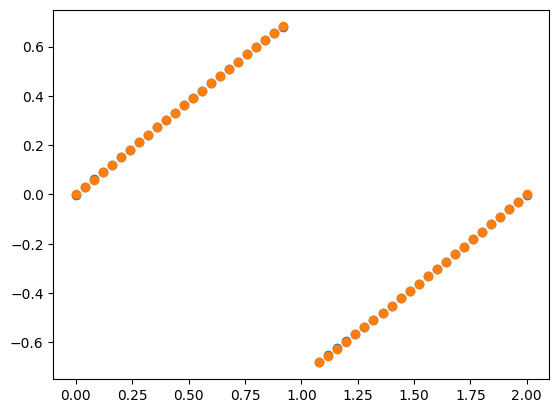

In [560]:
#x = np.linspace(0.0, 2.0, 50)                                  
t = np.linspace(1.0, 1.0, 1)                                        
t_grid, x_grid = np.meshgrid(t, x)                              
T = t_grid.flatten()[:, None]                                   
X = x_grid.flatten()[:, None]                                   
x_test = np.hstack((T, X))                                      
x_test = torch.tensor(x_test, requires_grad=True, dtype=torch.float32).to(device)
u_pred = to_numpy(pinn.net(x_test))
#res = to_numpy(model.res_pde(x_test))
#d   = to_numpy(model.lambda_pde(x_test))

#loss = model.loss_pde(x_test)                                 

import matplotlib.pyplot as plt
plt.figure()
plt.scatter(x,u_pred[:,0])
plt.scatter(x,ur)
plt.show()

# Refrence results

In [559]:
f = open('result.dat','r')
datae=[]
for i in f:
    i=i.strip('\n').split(" ")
    datae.append([float(t) for t in i])
#ref = np.zeros((10001,2))
x = []
ur =[]
#for i in range(10001):
#    xd =  datae[i][0]
#    ud =  datae[i][1]
for i in range(51):
    xd =  datae[i*200][0]
    ud =  datae[i*200][1]
    if (xd > 1.05 or xd < 0.95):
        x = np.append(x,xd)
        ur = np.append(ur,ud)

In [270]:
np.size(ur[:])

50

In [561]:
np.linalg.norm(u_pred[:,0] - ur[:], 2)/np.linalg.norm(ur[:], 2)

0.0005345465739167206

# Result

| Hidden layers | $N_f$ | $N_{ib}$ |Learning rate | $\varepsilon_1 $| $\varepsilon_2$|$L_2$ Error| Total   Loss| $L_2$ Error Orign| Total Loss Orign|
|--|--|-- |--        | --       |--  |--       | -- | -- |  --|
|$3 \times 30 \times 30$| $50\times 50$| 50| 1.0| 10 | 0.1| $5.1\times 10^{-4} $|  $7.3\times 10^{-6}$| $ 2.3\times 10^{-2}  $  | $ 8.7 \times 10^{-3}$|
|$\color{red}{ 3 \times 20 \times 20}$| $50\times 50$| 50| 1.0| 10 | 0.1| $1.1\times 10^{-3} $ |  $1.0\times 10^{-5}$| $3.0\times 10^{-2}$ | $8.2\times 10^{-3}$|
|$\color{red}{3 \times 40 \times 40}$| $50\times 50$| 50| 1.0| 10 | 0.1| $2.1\times 10^{-3} $ |  $8.2\times 10^{-6}$| $8.8\times 10^{-3}$ | $2.0\times 10^{-3}$|
|$3 \times 30 \times 30$| $\color{red}{100\times 100}$| $\color{red}{100}$| 1.0| 10 | 0.1| $5.0\times 10^{-4} $|  $4.8\times 10^{-5}$| $1.4 \times 10^{-2}$| $3.3\times 10^{-3}$|
|$3 \times 30 \times 30$| $\color{red}{25\times 25}$| $\color{red}{25}$| 1.0| 10 | 0.1| $1.8\times 10^{-3} $|  $6.0\times 10^{-6}$| $1.3 \times 10^{-2}$| $2.7\times 10^{-3}$|
|$3 \times 30 \times 30$| $50\times 50$| 50| $\color{red}{0.5}$| 10 | 0.1| $1.1\times 10^{-3} $|  $5.7\times 10^{-6}$| $ 7.2\times 10^{-3}  $  | $ 5.8 \times 10^{-4}$|
|$3 \times 30 \times 30$| $50\times 50$| 50| $\color{red}{1.5}$| 10 | 0.1| $7.0\times 10^{-4} $|  $2.2\times 10^{-5}$| $ 1.9\times 10^{-2}  $  | $ 4.0 \times 10^{-3}$|
|$3 \times 30 \times 30$| $50\times 50$| 50| 1.0| $\color{red}{20}$ | 0.1| $9.7\times 10^{-4} $|  $9.6\times 10^{-5}$| $ 1.1\times 10^{-2}  $  | $ 1.0 \times 10^{-3}$|
|$3 \times 30 \times 30$| $50\times 50$| 50| 1.0| $\color{red}{5}$ | 0.1| $7.2\times 10^{-4} $|  $1.6\times 10^{-5}$| $ 2.6\times 10^{-2}  $  | $ 5.5 \times 10^{-3}$|
|$3 \times 30 \times 30$| $50\times 50$| 50| 1.0| $10$ | $\color{red}{0.05}$| $7.1\times 10^{-4} $|  $3.0\times 10^{-5}$| $ 1.8\times 10^{-2}  $  | $ 3.6 \times 10^{-3}$|
|$3 \times 30 \times 30$| $50\times 50$| 50| 1.0| $10$ | $\color{red}{0.2}$| $1.2\times 10^{-3} $|  $9.2\times 10^{-5}$| $ 1.8\times 10^{-2}  $  | $ 3.6 \times 10^{-3}$|


# Output

In [124]:
new_array = np.array(u_pred[:,0])
file = open("burgers_u_we_11500.dat", "w+")
for i in range(u_pred.shape[0]):
    print(f'{x[i]}  {u_pred[i,0]} ',file=file)
file.close()

In [14]:
new_array = np.array(res[:,0])
file = open("burgers_res_w_5000.dat", "w+")
for i in range(u_pred.shape[0]):
    print(f'{x[i]}  {res[i,0]} ',file=file)
file.close()

In [57]:
file = open("burgers_d_w_14931.dat", "w+")
for i in range(d.shape[0]):
    print(f'{x[i]}  {1/d[i,0]} ',file=file)
file.close()